# Electricity Price Forecasting


### Project Framing

The main goal of this project is not to achieve an unique numeric value of an accurate precision while forecasting, but rather to forecast a minimal range of values in which the precision point is inserted. In other words, the exact numeric predicted value is not needed, but a range of values: low and high, in which the prediction might occur.

#### references:
- https://www.youtube.com/watch?v=HeQpGKNqkcs
- https://www.youtube.com/watch?v=H6du_pfuznE&t=1276s

In [2]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
sns.set()

### Data collection & Integration

This dataset as its source in the monthly available REN data and is referred to the daily market OMIE electricity market. It is important to notice that this data is in spanish timezone (GMT+1).

This dataset as a hourly periodicity and is composed by 3 columns: date and time, monthly file version and electricity price value

In [3]:
# import datafile, removed file row containiong title header - not important
df = pd.read_excel(r'C:\Users\ManuelSousa\Documents\VirtualEnvs\14_electricity_prices_forecast\docs\ren_liquidacao_precos_01-09-2016_31-12-2020_20210103.xlsx', skiprows=[0])
df.head()

,Data/Hora,Versão,Preço
0,2016-09-01 01:00,3,37.76
1,2016-09-01 02:00,3,36.00
2,2016-09-01 03:00,3,35.26
3,2016-09-01 04:00,3,35.26
4,2016-09-01 05:00,3,35.26


### Data Preparation & Cleaning

Its going to be created same aditional columns in respect to the temporal and seasonal characteristis of the electricity prices fluctuation. The added features makes this problem from a univariate to a multivariate. This columns might be later chosen as an relevant input feature. There are no null or missing values ones in the dataset.

In [4]:
# split data/hora column
df[['data', 'hora']] = df['Data/Hora'].str.split(" ", expand=True)
df['hora'] = df['hora'].str[:2].astype(int)
df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
# df = df.drop(columns=['Data/Hora', 'Versão'])
df = df.drop(columns=['Versão'])
df.set_index(['Data/Hora'], inplace=True)

# colunas temporais
df['diasemana'] = df['data'].dt.dayofweek
df['diaano'] = df['data'].dt.dayofyear
df['ano'] = df['data'].dt.year
df['mes'] = df['data'].dt.month
df['trimestre'] = df['data'].dt.quarter
df['semanaano'] = df['data'].dt.isocalendar().week
df['diames'] = df['data'].dt.day # Day of Month
# coluna de estacoes do ano
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = dict(zip(range(1,13), seasons))
df['estacoes'] = df['data'].dt.month.map(month_to_season) 

# DATASET OVERVIEW
df.describe().T
print(df.shape)
df.info()
print(df.skew())  # Skewness is a measure of asymmetry of a distribution - to analyse values distribution

(37992, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 37992 entries, 2016-09-01 01:00 to 2020-12-31 24:00
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Preço      37992 non-null  float64       
 1   data       37992 non-null  datetime64[ns]
 2   hora       37992 non-null  int32         
 3   diasemana  37992 non-null  int64         
 4   diaano     37992 non-null  int64         
 5   ano        37992 non-null  int64         
 6   mes        37992 non-null  int64         
 7   trimestre  37992 non-null  int64         
 8   semanaano  37992 non-null  UInt32        
 9   diames     37992 non-null  int64         
 10  estacoes   37992 non-null  int64         
dtypes: UInt32(1), datetime64[ns](1), float64(1), int32(1), int64(7)
memory usage: 3.2+ MB
Preço       -0.305915
hora         0.000000
diasemana    0.000000
diaano      -0.120966
ano         -0.136080
mes         -0.131264
trimestre   -0.130180
se

### Data Vizualization, Analysis, Exploration

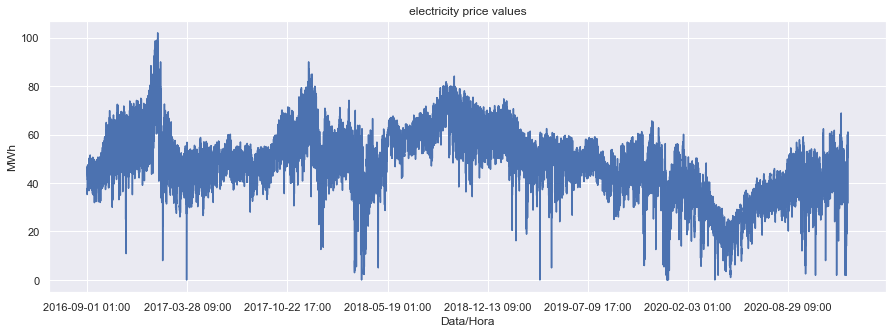

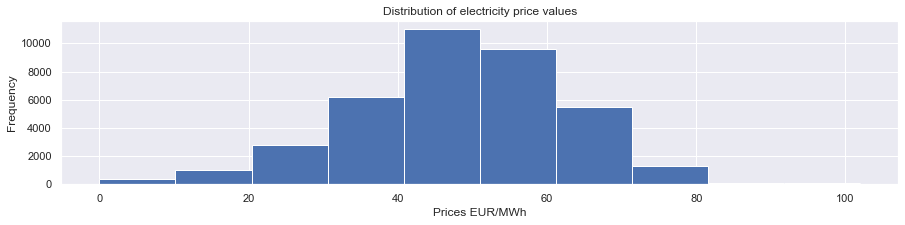

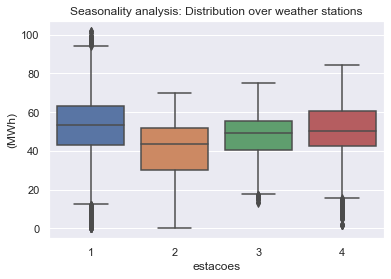

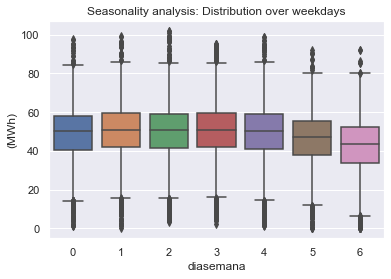

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


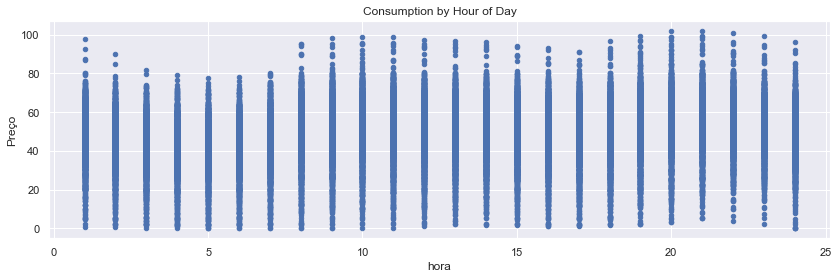

<AxesSubplot:title={'center':'Preços Average By Day'}, xlabel='hora'>

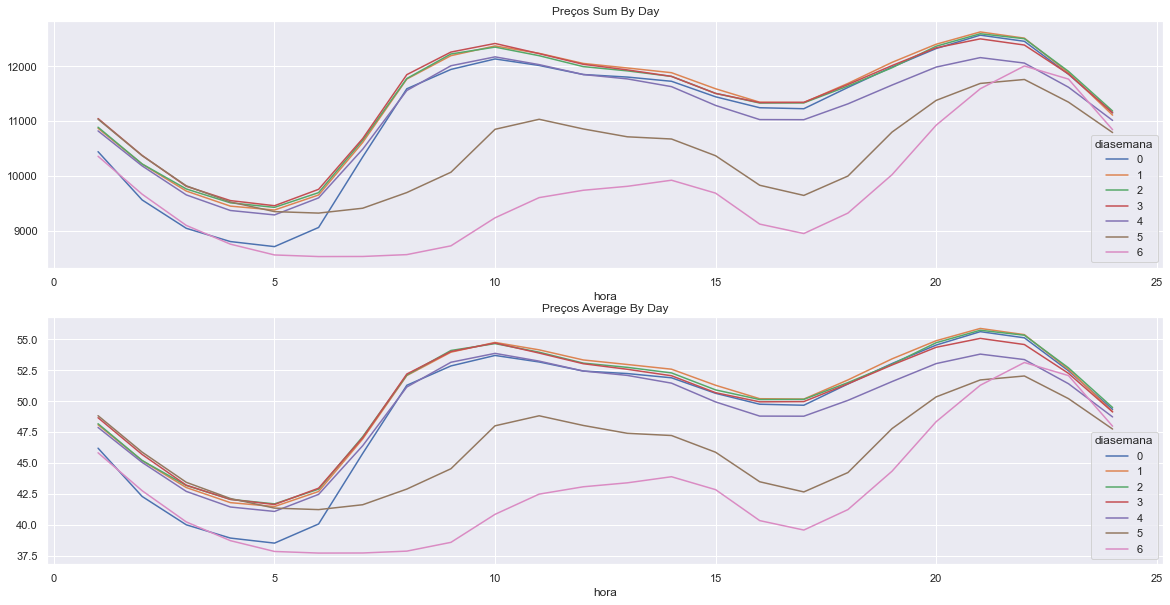

In [5]:
df['Preço'].plot(figsize=(15, 5), title='electricity price values')
plt.ylabel("MWh")
plt.show()

df['Preço'].plot.hist(figsize=(15, 3), title='Distribution of electricity price values')
plt.xlabel("Prices EUR/MWh")
plt.show()

sns.boxplot(data=df, x="estacoes", y="Preço")
plt.title("Seasonality analysis: Distribution over weather stations")
plt.ylabel("(MWh)")
plt.show()

sns.boxplot(data=df, x="diasemana", y="Preço")
plt.title("Seasonality analysis: Distribution over weekdays")
plt.ylabel("(MWh)")
plt.show()

# correlação entre todos as colunas criadas e disponeveis
# get_correlation('graph', df)

df[['Preço','hora']].plot(x='hora', y='Preço', kind='scatter', figsize=(14,4), title='Consumption by Hour of Day')
plt.show()


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
df.pivot_table(index=df['hora'], columns='diasemana', values='Preço', aggfunc='sum').plot(ax=axes[0], title='Preços Sum By Day')
df.pivot_table(index=df['hora'], columns='diasemana', values='Preço', aggfunc='mean').plot(ax=axes[1], title='Preços Average By Day')


# sns.pairplot(data=df)
# plt.title("Features Matrix Scatter Plot")
# plt.show()


In [6]:
def get_correlation(atype, dataframe):
    # Using Pearson Correlation
    # The correlation coefficient has values between -1 to 1
    # — A value closer to 0 implies weaker correlation (exact 0 implying no correlation)
    # — A value closer to 1 implies stronger positive correlation
    # — A value closer to -1 implies stronger negative correlation
    if atype == 'table':
        print(dataframe.corr())
    if atype == 'graph':
        plt.figure(figsize=(20,10))
        sns.heatmap(dataframe.corr(), annot=True, cmap=plt.cm.Reds)
        plt.show()

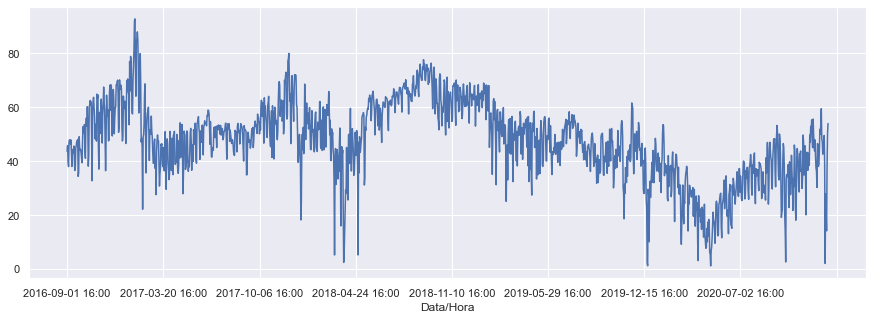

In [7]:
# g = sns.PairGrid(df[['Preço','hora']])
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot)
# g.add_legend()
x = df['Preço'].loc[df['hora'] == 16]
x.plot(figsize=(15, 5))
plt.show()

### Feature Selection & Engineering

- Lags creation;
- data normalization;
- feature selection; 
- outliers removal;
- data spliting: Training set, Testing set and small sample set (to evaluate model forecast ability).

In [8]:
from sklearn.preprocessing import MinMaxScaler

# BUILD DATASET LAGS TO TRAIN
# References
# https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/
# https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/

def create_lags(t_lags, dataset):
    # reframe as supervised learning
    dataframe = pd.DataFrame()
    for i in t_lags:
        dataframe['t-'+str(i)] = dataset.shift(i)
    return dataframe[t_lags[-1]:]

lags_list = [int(i) for i in range(1,350)]
lagged_dataset = create_lags(lags_list, df['Preço'])

# add experimental features - exogenous variables (why not?)
lagged_dataset['estacoes'] = df['estacoes'][lags_list[-1]:].astype('float')
lagged_dataset['diasemana'] = df['diasemana'][lags_list[-1]:].astype('float')
lagged_dataset['t'] = df['Preço'][lags_list[-1]:]
# target = pd.DataFrame()
# target['t'] = df['Preço'][lags_list[-1]:]

# print(target.head(), target.info())
# print(lagged_dataset.head(), lagged_dataset.describe())


# DATA NORMALIZATION/SCALING
# references
# https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
# https://www.baeldung.com/cs/data-normalization-before-after-splitting-set

# dont forget columns
cols = lagged_dataset.columns

# create scaler
scaler = MinMaxScaler()
# fit and transform in one step
lagged_dataset = scaler.fit_transform(lagged_dataset)
# inverse transform
# inverse = scaler.inverse_transform(normalized)

# data prepare
df_lag_dataset = pd.DataFrame(lagged_dataset, columns=cols)
# print(df_lag_dataset.shape)

# this portion of the dataset will be used for training phase purposes
df_lag_dataset = df_lag_dataset[0:-500]
# this sample dataset will be used to evaluate the model forecasting ability
df_sample = df_lag_dataset[-500:]
# print(df_lag_dataset.shape, df_sample.shape)

x_features = df_lag_dataset.iloc[:,:-1].values
y_target = np.hstack(df_lag_dataset.iloc[:,-1].values)

In [9]:
# FEATURE SELECTION
# Select the main features to build a model
# references
# https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/
# https://scikit-learn.org/stable/modules/feature_selection.html#rfe
# https://www.youtube.com/watch?v=wjKvyk8xStg
from sklearn.feature_selection import f_regression, mutual_info_regression

# define feature selection and 
fs = SelectKBest(score_func=f_regression, k=15)
# apply feature selection
X_features_selected = fs.fit_transform(x_features, y_target)
# Get columns to keep and create new dataframe with those only
# column indexes of selected features
cols = fs.get_support(indices=True)
print(cols)
# column names of selected features
features_df_new = df_lag_dataset.iloc[:,cols]
print(features_df_new.columns)


[  0   1   2   3   4   9  10  11  20  21  22  23  24  25 167]
Index(['t-1', 't-2', 't-3', 't-4', 't-5', 't-10', 't-11', 't-12', 't-21',
       't-22', 't-23', 't-24', 't-25', 't-26', 't-168'],
      dtype='object')


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest


# DATA SPLIT
# shuffle not applied and no validation set created
X_train, X_test, y_train, y_test = train_test_split(X_features_selected, y_target, test_size=0.2)
# summarize the shape of the training dataset
print("Training data: ", X_train.shape, y_train.shape)
print("Testing data: ", X_test.shape, y_test.shape)

# plt.figure(figsize=(10, 8))
# plt.subplot(211, title="Target Prices data - Histogram with 'auto' bins")
# plt.hist(y_train)
# plt.subplot(212, title="Target Prices with outliers")
# plt.plot(y_train)
# plt.show()

# OUTLIERS REMOVAL
# references
# https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/
# https://scikit-learn.org/stable/modules/outlier_detection.html
# https://www.pluralsight.com/guides/cleaning-up-data-from-outliers
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]
# summarize the shape of the updated training dataset
print("Training data without outliers: ", X_train.shape, y_train.shape)

# plt.figure(figsize=(10, 8))
# plt.subplot(211, title="Target Prices data WITHOUT outliers - Histogram with 'auto' bins")
# plt.hist(y_train)
# plt.subplot(212, title="Target Prices WITHOUT outliers")
# plt.plot(y_train)
# plt.show()


Training data:  (29714, 15) (29714,)
Testing data:  (7429, 15) (7429,)
Training data without outliers:  (26742, 15) (26742,)


### Model Training

As first implementation version its going to be trained a regular neural network with an sigmoid activation function

In [11]:
# references
# https://www.youtube.com/watch?v=-vHQub0NXI4
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# print(tf.__version__)

n_epochs = 100
nr_input_neurons = X_train.shape[1]

def build_model(input_neurons):
  model = keras.Sequential([
    layers.Dense(10, activation='sigmoid', input_shape=[input_neurons]),
    layers.Dense(1)
  ])

  # optimizer = tf.keras.optimizers.RMSprop(0.001) not being used
  model.compile(optimizer='adam',
                loss='mse',
                metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae'])
  return model

ann_model = build_model(nr_input_neurons)
ann_model.summary()

# O parâmetro patience é o quantidade de epochs para checar as melhoras
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
model_training = ann_model.fit(
  X_train, y_train,
  epochs=n_epochs,
  validation_split=0.2, callbacks=[early_stop], verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
669/669 [==============================] - 2s 2ms/step - loss: 0.0171 - root_mean_squared_error: 0.1230 - mae: 0.0949 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0525 - val_mae: 0.0414
Epoch 2/100
669/669 [==============================] - 1s 1ms/step - loss: 0.0024 - root_mean_squared_error: 0.0488 - mae: 0.0381 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0412 - val_mae: 0.0306
Epoch 3/100
669/669 [==============================] - 1s 1ms/step - loss: 0.0015 - root_mean_squared_error: 0

Epoch 37/100
669/669 [==============================] - 1s 1ms/step - loss: 5.3230e-04 - root_mean_squared_error: 0.0231 - mae: 0.0156 - val_loss: 5.5400e-04 - val_root_mean_squared_error: 0.0235 - val_mae: 0.0155
Epoch 38/100
669/669 [==============================] - 1s 1ms/step - loss: 5.3688e-04 - root_mean_squared_error: 0.0232 - mae: 0.0156 - val_loss: 5.3631e-04 - val_root_mean_squared_error: 0.0232 - val_mae: 0.0149
Epoch 39/100
669/669 [==============================] - 1s 1ms/step - loss: 5.4391e-04 - root_mean_squared_error: 0.0233 - mae: 0.0157 - val_loss: 5.4702e-04 - val_root_mean_squared_error: 0.0234 - val_mae: 0.0151
Epoch 40/100
669/669 [==============================] - 1s 1ms/step - loss: 5.5381e-04 - root_mean_squared_error: 0.0235 - mae: 0.0156 - val_loss: 5.9001e-04 - val_root_mean_squared_error: 0.0243 - val_mae: 0.0165
Epoch 41/100
669/669 [==============================] - 1s 1ms/step - loss: 5.2424e-04 - root_mean_squared_error: 0.0229 - mae: 0.0155 - val_los

Training evaluation: 
                                     59
loss                          0.000528
root_mean_squared_error       0.022977
mae                           0.015304
val_loss                      0.000534
val_root_mean_squared_error   0.023107
val_mae                       0.014741
epoch                        59.000000


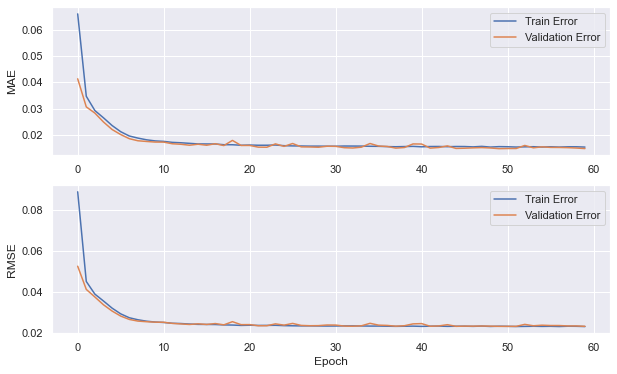

In [14]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  #   print(hist)
  hist['epoch'] = history.epoch    
  print("Training evaluation: \n", hist.tail(1).T)
    
  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6))
  axes[0].plot(hist['epoch'], hist['mae'], label='Train Error')
  axes[0].plot(hist['epoch'], hist['val_mae'], label = 'Validation Error')
  axes[0].legend()
  axes[0].set_ylabel('MAE')
  axes[1].plot(hist['epoch'], hist['root_mean_squared_error'], label='Train Error')
  axes[1].plot(hist['epoch'], hist['val_root_mean_squared_error'], label = 'Validation Error')
  axes[1].legend()
  axes[1].set_ylabel('RMSE')
  axes[1].set_xlabel('Epoch')

plot_history(model_training)


### Model Evaluation

Metrics:  ['loss', 'root_mean_squared_error', 'mae']
Test accuracy: [0.0005065341247245669, 0.022506313398480415, 0.015359781682491302]


Text(0, 0.5, 'Count')

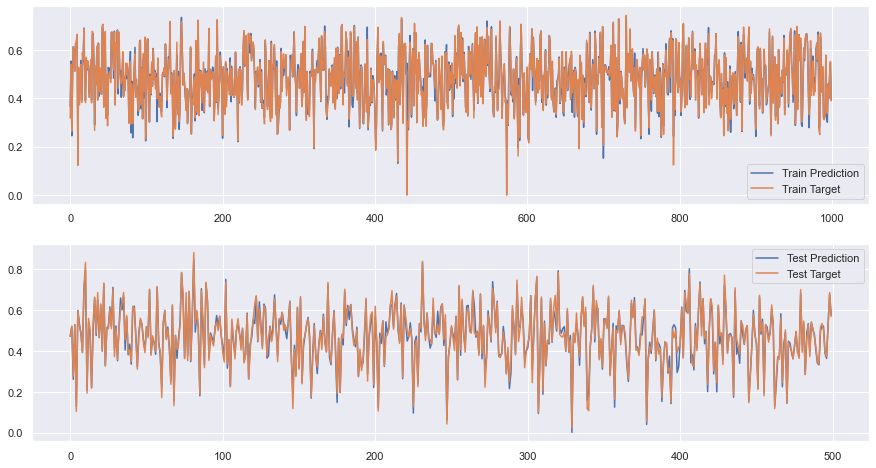

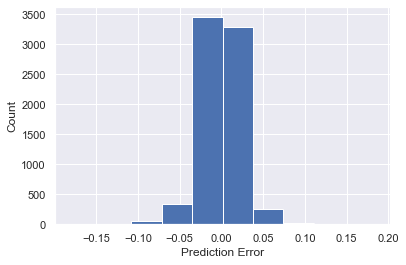

In [13]:
print("Metrics: ", ann_model.metrics_names)
test_lost = ann_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', test_lost) 

train_predictions = ann_model.predict(X_train).flatten()
test_predictions = ann_model.predict(X_test).flatten()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,8))
axes[0].plot(train_predictions[:1000], label='Train Prediction')
axes[0].plot(y_train[:1000], label = 'Train Target')
axes[0].legend()
axes[1].plot(test_predictions[:500], label='Test Prediction')
axes[1].plot(y_test[:500], label = 'Test Target')
axes[1].legend()

plt.figure()
error = test_predictions - y_test
plt.hist(error)
plt.xlabel("Prediction Error")
plt.ylabel("Count")